# Movie Producer Seeks Film Analysis

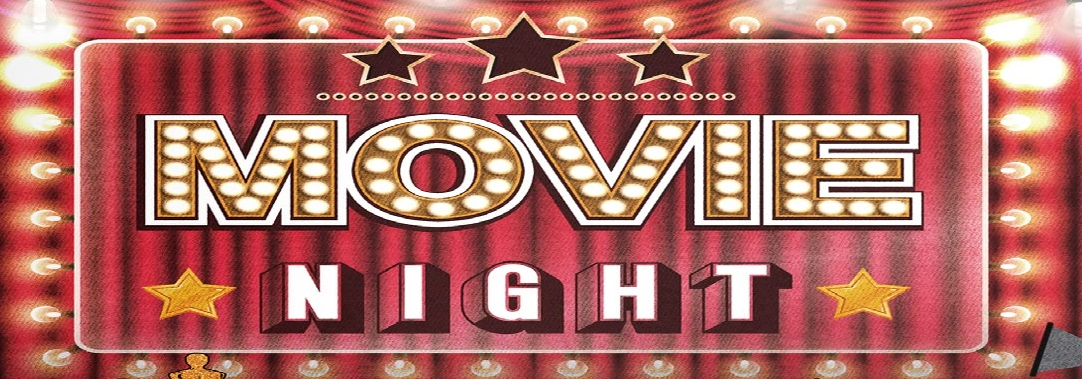

## Overview

This project analyzes the movie data from the Internet Movie Database (IMDB) and Box Office Mojo in order to determine what type of films are currently doing the best at the box office.  A descriptive analysis of domestic box office sales determines that specific studios, genres, and movie lengths are more successful than others. 

## Business Understanding

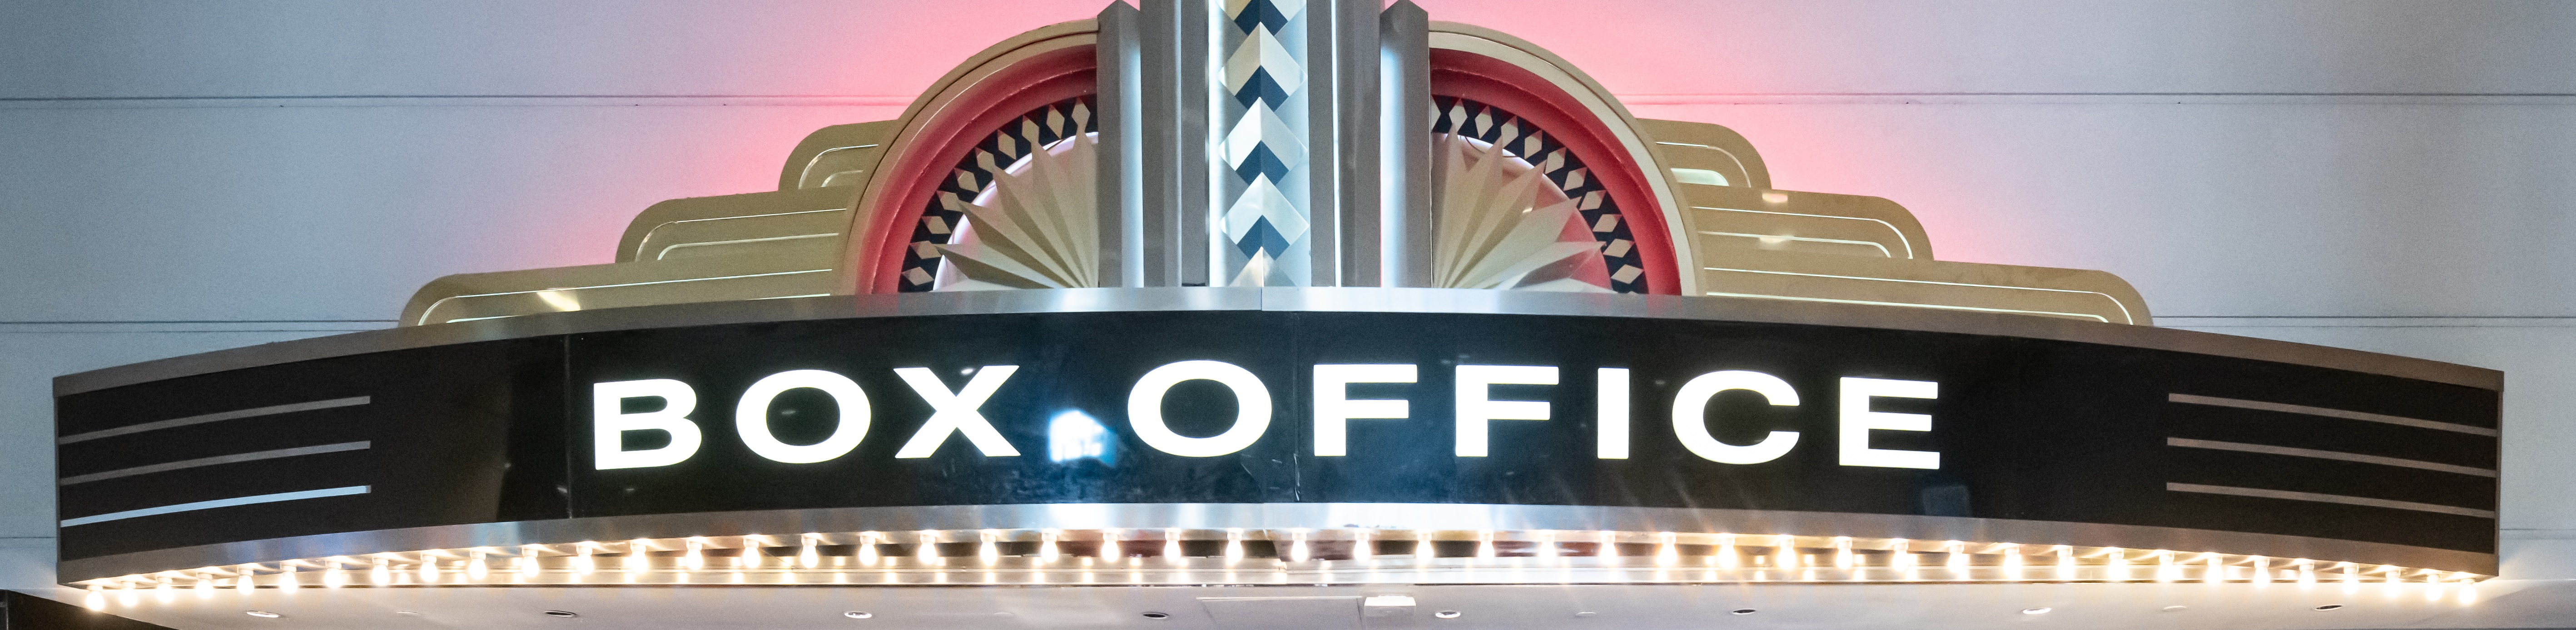

A company is looking to expand into the movie business.  They don't know anything about creating movies so they have hired me to to a descriptive analysis of the film industry.  They want to know what types of films are currently doing the best at the box office.  Using the movie data from the IMDB and Box Office Mojo, I describe patterns in the amount of domestic ticket sales movies made from 2010 to 2018 based on the studio that made the movie, the movie genre, and the length of the movie as the definition of success at the box office. 

## Data Understanding

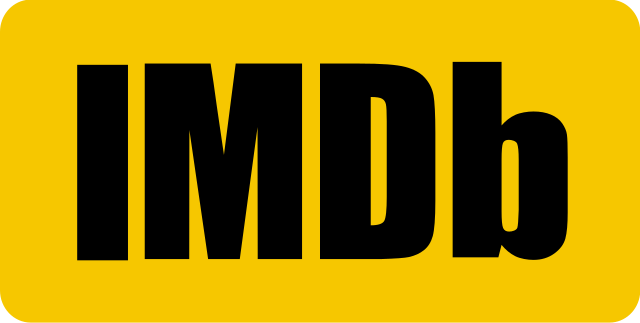

IMDB is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online.  The data contains information including cast, production crew, plot summaries, trivia, ratings, and reviews.  Box Office Mojo is a website that tracks box-office revenue in a systematic, algorithmic way.  The database I have contains 73,000 entries for movies from 2010 to 2027. The database contains 9 tables with various information including: movie_id, primary_title, start_year, runtime_minutes, genres, averagerating, numvotes, title, regions, etc.  The data from Box Office Mojo is in a csv format and contains 3,000 entries for moves from 2010 to 1018.  The data from Box Office Mojo contains: title, studio, domestic_gross, foreign_gross, and year.  These data are suitable for this project because the company is interested in knowing which films are doing the best at the box office and I have how much money the movies made at the box office and I have other data I can filter and sort by to find patterns in which characteristics of movies made the most money. 

In [9]:
#Import Necessary Libraries
import sqlite3
import pandas as pd
import plotly.express as px

#Connect to SQLLite3 Database
conn = sqlite3.connect('im.db')

In [10]:
#Load the CSV from Box Office Mojo
bom = pd.read_csv('bom.movie_gross.csv')

### Inspect the Contents of the Data

First, I insepct the csv file from Box Office Mojo.  I see that there are 3,356 entries into 5 columns containing information on movite titles, what studio made the movie, how much money it made domestically, how much money it made internationally, and what year it was released.  I also looked at the entity relationship diagram (ERD) for the im.db. The features I'm interested in from the database are movie_id, primary_title, start_year, runtime_minutes, genres, and average rating. 

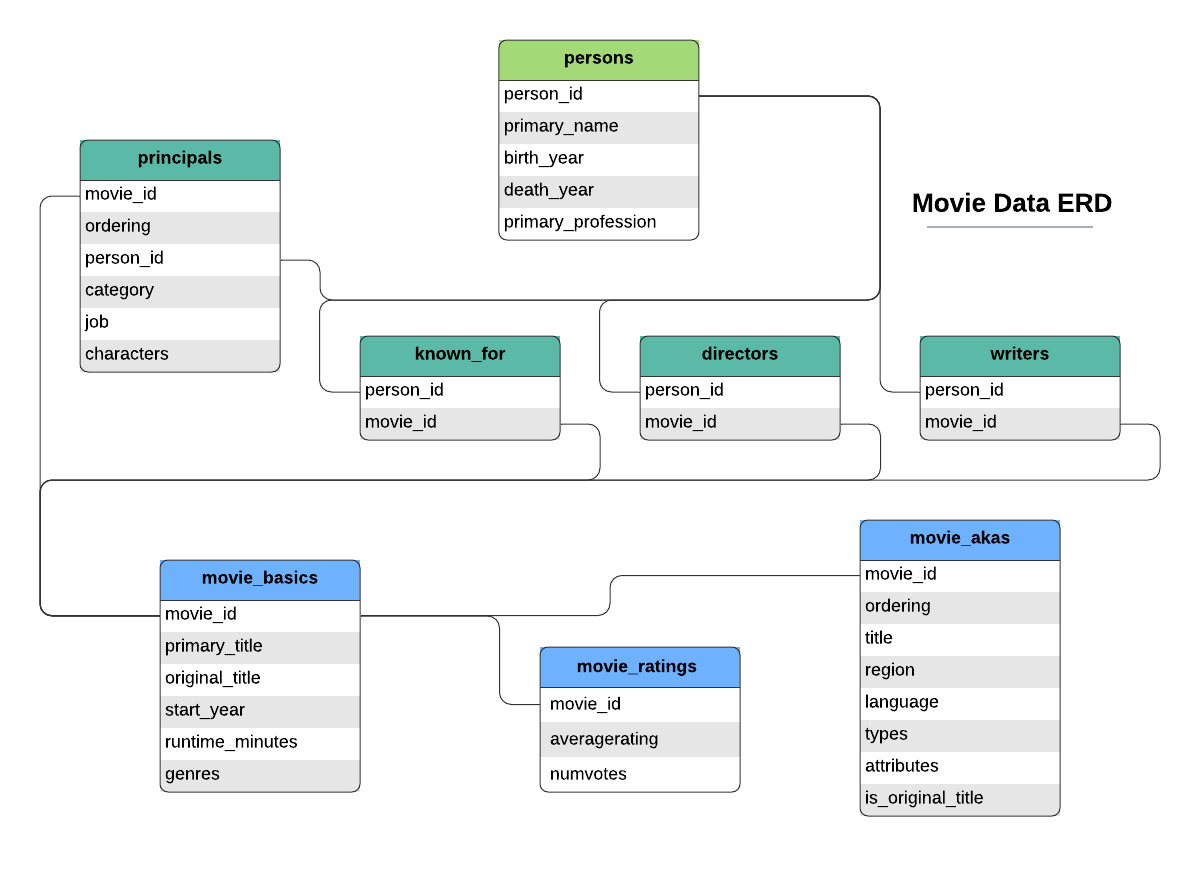

In [11]:
#Inspect the column names and the first 5 rows of data from the Box Office Mojo csv
bom.head()

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010

In [120]:
#See how many data entries there are
bom.shape

(3356, 4)

In [13]:
#See what dattypes the features are
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Descriptive Statistics for Selected Features in Analysis

I looked at the value counts for the title, studio, and year to see how many unique values each feature contained.  I also looked at the aggregate statistics for domestic movie sales.  The only anomoly that stood out was there were two movies with the same title "Bluebeard".  I checked to see if this was a duplicate entry and found that it was two movies with the same name produced by different studios in diffferent years.  I include all of these features because I'm going to compare the domestic sales of movies by movie studio.  I need the title as an index column and I'm going to use the year to see how movie sales have changed over time. I also looked at the descriptive statistics for the values I'm interested in from the database. 

In [121]:
#Unique Values of Movie Titles
bom['title'].value_counts()

Bluebeard                    2
Bernie                       1
Money Monster                1
Secretariat                  1
The Dance of Reality         1
                            ..
Ghostbusters (2016)          1
The East                     1
Klown                        1
Riddick                      1
War of the Buttons (2012)    1
Name: title, Length: 3355, dtype: int64

In [125]:
#I inspect these rows and see that they are two separate movies made by two different studios in two different years so they aren't duplicates
bluebeard = bom[bom['title'] == 'Bluebeard']
print(bluebeard)

          title  studio  domestic_gross  year
317   Bluebeard  Strand         33500.0  2010
3045  Bluebeard   WGUSA         43100.0  2017


In [122]:
#Unique Names for Movie Studios
bom['studio'].value_counts()

IFC       166
Uni.      147
WB        140
Fox       136
Magn.     136
         ... 
CFilms      1
DR          1
DF          1
ALP         1
Argo.       1
Name: studio, Length: 255, dtype: int64

In [15]:
#Statistics for Domestic Movie Sales
bom['domestic_gross'].describe()

count    3.359000e+03
mean     2.874585e+07
std      6.698250e+07
min      1.000000e+02
25%      1.200000e+05
50%      1.400000e+06
75%      2.790000e+07
max      9.367000e+08
Name: domestic_gross, dtype: float64

In [124]:
#Number of movies per year
bom['year'].value_counts()

2015    449
2016    433
2011    396
2012    393
2014    390
2013    345
2010    322
2017    320
2018    308
Name: year, dtype: int64

For this query I looked at the count of categorical data from each category I was interested in.  I also looked at the descriptive statistics for runtime and rating.  

In [133]:
#Descriptive Statistics for im.db
query_describe = """
SELECT
    COUNT(mb.movie_id) AS num_of_movies, 
    COUNT(mb.primary_title) AS num_of_titles, 
    COUNT(mb.start_year) AS num_per_year, 
    COUNT(mb.runtime_minutes) as count_runtime, 
    MIN(mb.runtime_minutes) as min_runtime, 
    MAX(mb.runtime_minutes) as max_runtime, 
    AVG(mb.runtime_minutes) as avg_runtime, 
    COUNT(mb.genres) as num_of_genres, 
    COUNT(mr.averagerating) as count_ratings, 
    MIN(mr.averagerating) as min_rating,  
    MAX(mr.averagerating) as max_rating, 
    AVG(mr.averagerating) as avg_rating
FROM 
    movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
;
"""

pd.read_sql(query_describe, conn)

num_of_movies  num_of_titles  num_per_year  count_runtime  min_runtime  \
0          73856          73856         73856          66236          3.0   

   max_runtime  avg_runtime  num_of_genres  count_ratings  min_rating  \
0      51420.0     94.65404          73052          73856         1.0   

   max_rating  avg_rating  
0        10.0    6.332729

## Data Preparation

### Identify and Handle Missing Values

In this section I check to see if there are any missing data. First, I dropped any duplicate data if there are any.  When I further inspect the data I see that the foreign_gross has 1,350 null entries out of 3,387 entries (~40%).  I also see that it is an object when I would expect it to be a float or integer.  With such a large amount of missing data and the incorrect datatype I'm going to remove this feature from the data and focus my analysis on domestic movie sales.  So, I dropped the column foreign_gross next.  Then I checked for any missing values.  I saw there were missing values in the studio and domestic_gross feature.  Since they made up a small percentage of the total data I went ahead and dropped those data.  Finally, I imported the cleaned data into the database so I can compare it with the other data in the database. 

In [126]:
bom = bom.drop_duplicates()

In [ ]:
###foreign gross is missing 40% of its data so I'm going to drop that column and focus on domestic gross for this analysis
bom.drop(columns = ['foreign_gross'], inplace = True)

In [17]:
bom.isna().sum()

title              0
studio             5
domestic_gross    28
year               0
dtype: int64

In [18]:
#dropp the rows with missing values from studio and domestic gross which are important values for my analysis
bom.dropna(subset = ['studio', 'domestic_gross'], inplace = True)

In [19]:
bom.isna().sum()

title             0
studio            0
domestic_gross    0
year              0
dtype: int64

In [20]:
#Import CSV as a table in the db so that all the data is in one place
bom.to_sql('movie_gross', conn, if_exists='append', index=False)

## Data Analysis

For my analysis I want to look at the domestic movie sales to determine which studio, genres, and runtime to recommend to the company. For the analysis I used sqllite3 to query data from the im.db database.  I used aggregate functions, joins, group by, and limit to group and filter data from multiple tables. 

### Movie Sales

The first thing I looked at is this a reasonable endeavor for my company to get into.  I looked at the amount of domestic_gross sales that have been made throughout the dataset.  I found that from 2010 to 2018 the amount of movie sales is increasing.  Therefore, this is a reasonable endeavor for my company to get into. 

In [88]:
#In this query I look at the total amount of movie sales grouped by year from the table I made from the Box Office Mojo csv

query_sales = """
SELECT 
    year,
    SUM(domestic_gross) AS Movie_Sales
FROM movie_gross
GROUP BY year
;
"""

results_sales = pd.read_sql(query_sales, conn)
results_sales

year   Movie_Sales
0  2010  4.062741e+10
1  2011  4.025642e+10
2  2012  4.350642e+10
3  2013  4.316932e+10
4  2014  4.135093e+10
5  2015  4.420562e+10
6  2016  4.501461e+10
7  2017  4.373306e+10
8  2018  4.436484e+10

In [89]:
#I made a line chart to show how the amount of domestic movie sales have changed over time
fig_sales = px.line(results_sales, x='year', y='Movie_Sales', title = 'Movie Sales Over Time')
fig_sales.show()

### Movie Sales by Studio

Next I looked at the total amount of domestic movie sales and grouped them by studio.  I limited it to the top 6 studios to make a recommendation based on which studio has made the most money.  I found that Buena Vista, a subsidiary of Disney, has had the most domestic box office sales between 2010 and 2018.  I would recommend that my company hire Buena Vista, Universal, or Warner Brothers to produce their film because of the money their films have made.

In [54]:
#In this query I look at the top 6 total domestic movie sales grouped movie studio from the Box Office Mojo csv

query_studio = """
SELECT
    studio,
    SUM(domestic_gross) AS Total_Sales
FROM
    movie_gross
GROUP BY studio
ORDER BY Total_Sales DESC
LIMIT 6
;
"""

results_studio = pd.read_sql(query_studio, conn)
results_studio

studio   Total_Sales
0     BV  7.367612e+10
1   Uni.  5.160957e+10
2     WB  4.867218e+10
3    Fox  4.379800e+10
4   Sony  3.383873e+10
5   Par.  3.074348e+10

In [52]:
#I made a bar graph to show the amount of domestic sales grouped by the top 6 movie studios
fig_studio = px.bar(results_studio, x = 'studio', y='Total_Sales', title = 'Movie Sales by Studio', color = 'studio')
fig_studio.show()

### Movie Sales by Genre

Next, I looked at the domestic move sales based on the movie genre.  The genres in the database had either one, two, or three generes all in the same feature.  In order to analyze this I used a string split method to separate the genres into three different features.  Then I looked at the primary genre (genre1) to determine which genre made the most money.  There were 19 different genres in the database with action movies having the highest amount of domestic income. I recommend the company produce an action movie. 

In [60]:
#In this query I looked at the domestic sales from Box Office Mojo and compared them to the genres from the im.db
query_genre = """
SELECT
    mb.genres,
    mg.domestic_gross
FROM
    movie_basics AS mb
        JOIN movie_gross AS mg
            ON mb.primary_title = mg.title
;
"""

results_genre = pd.read_sql(query_genre, conn)
results_genre

genres  domestic_gross
0           Action,Crime,Drama       1100000.0
1           Action,Crime,Drama       1100000.0
2           Action,Crime,Drama       1100000.0
3           Action,Crime,Drama       1100000.0
4      Adventure,Drama,Romance        744000.0
...                        ...             ...
13384                    Crime        613000.0
13385              Documentary      81600000.0
13386              Documentary      81600000.0
13387              Documentary      81600000.0
13388              Documentary      81600000.0

[13389 rows x 2 columns]

In [61]:
#I split the string in 'genres' into three features by splitting the string at the comma
results_genre[['Genre1', 'Genre2', 'Genre3']] = results_genre['genres'].str.split(',', expand = True)
results_genre

genres  domestic_gross       Genre1 Genre2   Genre3
0           Action,Crime,Drama       1100000.0       Action  Crime    Drama
1           Action,Crime,Drama       1100000.0       Action  Crime    Drama
2           Action,Crime,Drama       1100000.0       Action  Crime    Drama
3           Action,Crime,Drama       1100000.0       Action  Crime    Drama
4      Adventure,Drama,Romance        744000.0    Adventure  Drama  Romance
...                        ...             ...          ...    ...      ...
13384                    Crime        613000.0        Crime   None     None
13385              Documentary      81600000.0  Documentary   None     None
13386              Documentary      81600000.0  Documentary   None     None
13387              Documentary      81600000.0  Documentary   None     None
13388              Documentary      81600000.0  Documentary   None     None

[13389 rows x 5 columns]

In [72]:
#Here I made a histogram showing the domestic income grouped by genre
fig_genre = px.histogram(results_genre, x='Genre1', y = 'domestic_gross', barmode = 'group', title = 'Movie Sales by Genre')
fig_genre.update_layout(xaxis={'categoryorder':'total descending'})
fig_genre.show()

### Movie Sales by Runtime

Finally, I looked at the length of the movie to determine if movies have more domestic sales depending on how long the movie is. I selected the runtime minutes and the domestic gross sales by joining the movie basics and movie gross tables.  Then I made a histogram to see if specific movie lengths are more successful than others.  I found a normal distribution of movie sales around movies that are 100 - 119 minutes.  I recommend the company produce a film that has a length in this range. 

In [135]:
#Here I query runtime and domestic gross by joining the movie gross and movie basics tables
query_runtime = """
SELECT
    mb.runtime_minutes,
    mg.domestic_gross
FROM
    movie_gross AS mg
        JOIN movie_basics AS mb
            ON mg.title = mb.primary_title

;
"""

results_runtime = pd.read_sql(query_runtime, conn)
results_runtime

runtime_minutes  domestic_gross
0                103.0     415000000.0
1                148.0     292600000.0
2                 93.0     238700000.0
3                124.0     300500000.0
4                124.0     312400000.0
...                ...             ...
13384             86.0         11400.0
13385             90.0         11400.0
13386            100.0          8900.0
13387            106.0          6200.0
13388             97.0          1700.0

[13389 rows x 2 columns]

In [87]:
#Here I make a histogram showing the relationship between movie runtime and domestic sales
fig_runtime = px.histogram(results_runtime, x='runtime_minutes', y = 'domestic_gross', nbins = 60, title = 'Movie Sales by Runtime')
fig_runtime.show()

### Movie Sales vs. Rating

In this section I wanted to see if there was a relationship between user rating on imdb and box office sales.  I found that there is a small linear relationship between the two.  However, the top 6 selling films had a user rating between 7 and 8.5 so it doesn't seem that making the most money has the highest user rating. 

In [ ]:
# I joined the movie gross and movie ratings tables using the movie basics table to select average rating and domestic gross
query_ratings_sales = """
SELECT
    mb.genres,
    mr.averagerating,
    mg.domestic_gross
FROM
    movie_gross AS mg
        JOIN movie_basics AS mb
            ON mg.title = mb.primary_title
                JOIN movie_ratings AS mr
                    ON mb.movie_id = mr.movie_id
;
"""

results_ratings_sales = pd.read_sql(query_ratings_sales, conn)
results_ratings_sales

In [136]:
#Here I made a scatter plot with a trendline showing the relationship between average rating and domestic gross
fig_ratings_sales = px.scatter(results_ratings_sales, x='averagerating', y='domestic_gross', trendline ='ols', title = 'Movie Sales vs. Ratings')
fig_ratings_sales.show()

## Conclusions

This analysis leads to three recommendations for the company to produce. 

- __Produce a movie using the Buena Vista Studio.__ Buena Vista studio earned *22 billion* more in domestic income than the next closest movie studio.  They have a best record of success at the box office during the study period.
<br>

- __Produce an action movie.__ Action films made *62 billion* more in domestic income than the next closest movie genre.  They have the best record of success at the bo office during the study period. 
<br>

- __Produce a movie between 100 and 119 minutes long.__ Movies produced with a runtime between 100 and 119 minutes earned *29 billion* more in domestic income than the next closest runtime category.  They have the best record of success at the box office during the study period. 

## Next Steps

Further Analysis could yield additional insights into which movies have the highest domestic sales: 

- __Better understanding of the cast and crew.__ Modeling the impact of high level production crew and cast on the success of the film. 
<br>

- __Production Budget__ Analysis of the net budget of the film may give a better understanding of success. Is it better to spend a large budget on the production of the film and have a high income or to spend a small budget and make a smaller income.  Is there a relationship between budget and income? 
<br>
- __Advertising__  What does the role of advertising money play in the success of the movie?  What type of advertising produces the largest return? 